In [2]:
# use asynccio to fuse event loop of tensorflow to jupyter, so not producing creating duplicated event loop error
import nest_asyncio
nest_asyncio.apply()

In [3]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

tf.compat.v1.enable_v2_behavior()

np.random.seed(0)

In [4]:
# Loaded federated version of MNIST dataset (key by writter of each data entry to represent i.i.d)
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

In [5]:
# see number of writter key (possible federated partition number)
len(emnist_train.client_ids)

3383

In [6]:
# training data format
emnist_train.element_type_structure

OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)),
             ('pixels',
              TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])

In [7]:
# try getting 1 data sample from writer 1
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

example_element = next(iter(example_dataset))

example_element['label'].numpy()

5

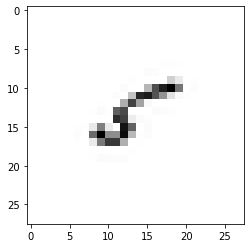

In [8]:
# visualize it
from matplotlib import pyplot as plt
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
_ = plt.show()

In [9]:
# create function to preprocess dataset (flatten and convert from 'pixels','label' to 'x', 'y')
NUM_CLIENTS = 2
NUM_EPOCHS = 1
BATCH_SIZE = 5
SHUFFLE_BUFFER = 10
PREFETCH_BUFFER=10

def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    return collections.OrderedDict(
        x=tf.reshape(element['pixels'], [-1, 784]),
        y=tf.reshape(element['label'], [-1, 1]))

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [10]:
# try getting and printing 1 batch of data
preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

sample_batch

OrderedDict([('x',
              array([[1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)),
             ('y',
              array([[4],
                     [2],
                     [1],
                     [4],
                     [3]], dtype=int32))])

In [11]:
# helper function to create list of dataset for each fenerated node
def make_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]

In [12]:
# call the function to create federated data (only for subset of writter key for experimental)
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients)

print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

Number of client datasets: 2
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


In [13]:
# function to create simple keras model
def create_keras_model():
  return tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=(784,)),
      tf.keras.layers.Dense(10, kernel_initializer='zeros'),
      tf.keras.layers.Softmax(),
  ])

In [14]:
# wrap it inside the function to convert keras model to TFF model
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [15]:
# created federated training operation
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [16]:
# see federated initialization operation (auto-genererated by TFF)
str(iterative_process.initialize.type_signature)

'( -> <model=<trainable=<float32[784,10],float32[10]>,non_trainable=<>>,optimizer_state=<int64>,delta_aggregate_state=<>,model_broadcast_state=<>>@SERVER)'

In [17]:
# invoke initialization to create initial model and optimizer state on server
state = iterative_process.initialize()

In [ ]:
# run 1 round of federated training (1 distribute, 1 collect and 1 update weight on server side)
state, metrics = iterative_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))